# Age Estimation
In this lab, we will implement our own designed Convolutional Neural Network(CNN).

First please download image dataset(APPA-REAL DATABASE) from http://chalearnlap.cvc.uab.es/dataset/26/data/45/description/, and unzip it. Copy this folder to DATASET. The files struction should looks like:

```
-----Network
    |
    |---- DATASET
    |    |-- appa-real-release
    |    |-- valid
    |    |-- feature_test.npy
    |    |-- feature_train.npy
    |    ...
    |---- helperP.pyc
    |---- helperT.pyc
    |---- ignore_list.csv
    |---- networkCustom.ipynb
    |---- pynetworkHidden.ipynb
           
           
           
```

In [0]:
import os
import numpy as np
from helperT import *

# Loading Data
At the heart of PyTorch data loading utility is the torch.utils.data.DataLoader class. It represents a Python iterable over a dataset. The function will return `train_loader`, `val_loader` and `test_loader` three data loaders. The training dataset has 3,995 labeled images, validation dataset has 1,500 labeled images, and testing dataset has 500 imgages, all of these are collected from APPA Dataset.

In the transform function, we will randomly add some Gaussian blur and noise, random flip, crop, rotate also added to traning and validation process. Don't worry, we have already integrated these for you. You can just using an python `enumerate` function to iterate those datasets.

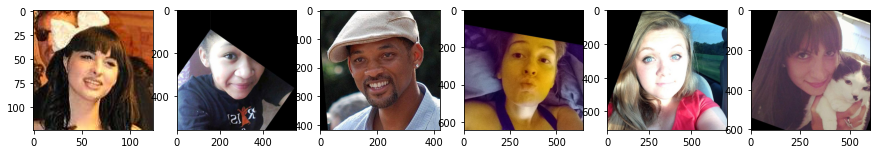

In [8]:
base_dir = 'DATASET/'
train_loader, val_loader, test_loader = get_img_dataloaders(base_dir)
show_data(base_dir)

# Network Structure
The torch.nn  module is the cornerstone of designing neural networks in PyTorch. This class can be used to implement a layer like a fully connected layer, a convolutional layer, a pooling layer, an activation function, and also an entire neural network by instantiating a torch.nn.Module object. 

The nn.Module class has two methods that you have to override.

- `__init__ `function. This function is invoked when you create an instance of the nn.Module. Here you will define the various parameters of a layer such as filters, kernel size for a convolutional layer, dropout probability for the dropout layer.
- `forward` function. This is where you define how your output is computed. This function doesn't need to be explicitly called, and can be run by just calling the nn.Module instance like a function with the input as it's argument.

Another widely used and important class is the nn.Sequential class.  When initiating this class we can pass a list of nn.Module objects in a particular sequence. The object returned by nn.Sequential is itself a nn.Module object. When this object is run with an input, it sequentially runs the input through all the nn.Module object we passed to it, in the very same order as we passed them.

After we defined our computing graph, we have to intitialize our networks's weights. You could try with Xavier initialization, or Kaiming initialization. If you want to get a better score in the end, adding batch normalization to the convolution layers is a good choice.

Here's some class or function might be useful for you:
- `nn.Conv2d()`
- `nn.MaxPool2d()`
- `nn.Sequential()`
- `nn.AdaptiveAvgPool2d()`
- `nn.Linear()`
- `nn.ReLU()`
- `nn.Dropout()`


Our CNN network designed as structure below:

| Layer name | kernel size | padding | activation | stride | (fan_in,fan_out) |
| ---------- | ----------- | ------- | ---------- | ------ | ---------------- |
| CONV64     | 7           | 3       | ReLU       |        |       (3,64)     |
| maxpool    | 2           |         |            | 2      |                  |
| CONV128-1  | 5           | 2       | ReLU       |        |     (64,128)     |
| CONV128-2  | 5           | 2       | ReLU       |        |    (128,128)     |
| maxpool    | 2           |         |            | 2      |                  |
| CONV256-1  | 3           | 1       | ReLU       |        |    (128,256)     |
| CONV256-2  | 3           | 1       | ReLU       |        |    (256,256)     |
| CONV256-3  | 3           | 1       | ReLU       |        |    (256,256)     |
| maxpool    | 2           |         |            | 2      |                  |
| CONV512-1  | 3           | 1       | ReLU       |        |    (256,512)     |
| CONV512-2  | 3           | 1       | ReLU       |        |    (512,512)     |
| CONV512-3  | 3           | 1       | ReLU       |        |    (512,512)     |
| maxpool    | 2           |         |            | 2      |                  |
| CONV512-4  | 3           | 1       | ReLU       |        |    (512,512)     |
| CONV512-5  | 3           | 1       | ReLU       |        |    (512,512)     |
| CONV512-6  | 3           | 1       | ReLU       |        |    (512,512)     |
| maxpool    | 2           |         |            | 2      |                  |
| FC1        |             |         | ReLU       |        |  (512x4x4,4096)  |
| FC2        |             |         | ReLU       |        |    (4096,4096)   |
| FC3        |             |         |            |        |    (4096,101)    |

In [9]:
'''
 INPUTS   ---------------->  128x128x64  ---------------->  64x64x64   
128x128x3     CONV-64              maxpool                       

  ---------------->  64x64x128   ---------------->  64x64x128  ---------------->  32x32x128
    CONV128-1             CONV128-2             maxpool
  
  ---------------->  32x32x256   ---------------->  32x32x256   ---------------->  32x32x256  ---------------->  16x16x256
    CONV256-1             CONV256-2             CONV256-3             maxpool
       
  ---------------->  16x16x512   ---------------->  16x16x512   ---------------->  16x16x512  ---------------->   8x8x512
    CONV512-1             CONV512-2             CONV512-3             maxpool

  ---------------->    8x8x512   ---------------->   8x8x512  ---------------->   8x8x512   ---------------->   4x4x512
    CONV512-4             CONV512-5             CONV512-6             maxpool
  
  4x4x512 ----------->  FC1  -----------> FC2  ----------->  FC3
              4096        4096          101

'''

'\n INPUTS   ---------------->  128x128x64  ---------------->  64x64x64   \n128x128x3     CONV-64              maxpool                       \n\n  ---------------->  64x64x128   ---------------->  64x64x128  ---------------->  32x32x128\n    CONV128-1             CONV128-2             maxpool\n  \n  ---------------->  32x32x256   ---------------->  32x32x256   ---------------->  32x32x256  ---------------->  16x16x256\n    CONV256-1             CONV256-2             CONV256-3             maxpool\n       \n  ---------------->  16x16x512   ---------------->  16x16x512   ---------------->  16x16x512  ---------------->   8x8x512\n    CONV512-1             CONV512-2             CONV512-3             maxpool\n\n  ---------------->    8x8x512   ---------------->   8x8x512  ---------------->   8x8x512   ---------------->   4x4x512\n    CONV512-4             CONV512-5             CONV512-6             maxpool\n  \n  4x4x512 ----------->  FC1  -----------> FC2  ----------->  FC3\n              4

In [0]:
class AgeNet(nn.Module):
        def __init__(self):
            super(AgeNet, self).__init__()
            ##########################################################################
            # TODO: YOUR CODE HERE
            ##########################################################################        
            # define the network

        
            self._initialize_weights()

        def forward(self, x):
            ##########################################################################
            # TODO: YOUR CODE HERE
            ##########################################################################
            # forward calculation
            
            output = None
            return output

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)



# Training and validation

In [0]:
def train_ageNet():

    # set the parameters for optimization (all should be kept same)
    EPOCH  = 100
    TRAIN_LR = 0.001   #Learning rate
    MOMENTUM = 0.9    #SGD Momemutm


    ##########################################################################
    # TODO: YOUR CODE HERE
    ##########################################################################   
    # Instantiate the AgeNet


    # Move the model to gpu (in Colab you have one)


    # Define the SGD optimizer

    
    # Define the creterion


    # Set the intial value for validation error
    loss_opt = 1e6

    for e in range(EPOCH):
        # Training
        model.train()

        ##########################################################################
        # TODO: YOUR CODE HERE
        ########################################################################## 
        for i, (y, x) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda().long()
            # Calculate the forward pass

            # Calculate the gradient and update the model

        ##########################################################################
        # TODO: YOUR CODE HERE
        ########################################################################## 
        # Validationu
        model.eval()
        gtsVal = []     # save all the ground truth for validation set (saved in numpy format)
        predsVal = []   # save all the  predictions for validation set (saved in numpy format)

        for i, (y, x) in enumerate(val_loader):
            x, y = x.cuda(), y.cuda().long()
            # calculate the predictions on validation set

        ##########################################################################
        # TODO: YOUR CODE HERE
        ########################################################################## 
        # calculate the mean absolute error on validation set
        mae = None

        ##########################################################################
        # TODO: YOUR CODE HERE
        ########################################################################## 
        if(mae < loss_opt):
            loss_opt = mae
            # save the model if mae reaches the optimum


    print("=> training finished")
    return predsVal, gtsVal



True
AgeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AgeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


=> [epoch 0001] mae validation: 13.92707 loss: 4.004
=> [epoch 0002] mae validation: 11.64948 loss: 3.657
=> [epoch 0003] mae validation: 12.07936 loss: 3.752
=> [epoch 0004] mae validation: 11.31330 loss: 3.653
=> [epoch 0005] mae validation: 11.23484 loss: 3.449
=> [epoch 0006] mae validation: 11.61628 loss: 3.782
=> [epoch 0007] mae validation: 11.18670 loss: 3.579
=> [epoch 0008] mae validation: 11.26835 loss: 3.723
=> [epoch 0009] mae validation: 11.22501 loss: 3.539
=> [epoch 0010] mae validation: 11.04153 loss: 3.490
=> [epoch 0011] mae validation: 11.40257 loss: 3.689
=> [epoch 0012] mae validation: 11.07314 loss: 3.446
=> [epoch 0013] mae validation: 11.11637 loss: 3.569
=> [epoch 0014] mae validation: 11.27480 loss: 3.631
=> [epoch 0015] mae validation: 10.96042 loss: 3.393
=> [epoch 0016] mae validation: 10.95615 loss: 3.679
=> [epoch 0017] mae validation: 10.94433 loss: 3.589
=> [epoch 0018] mae validation: 11.14546 loss: 3.739
=> [epoch 0019] mae validation: 10.70474 loss:

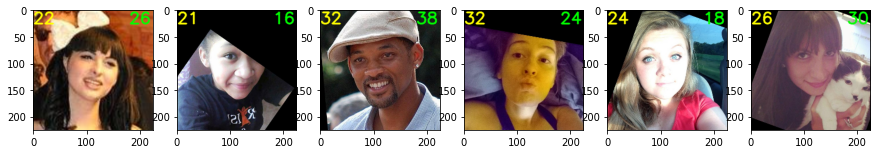

In [12]:
#if __name__ == "__main__":
print(torch.cuda.is_available())
preds, gt = train_ageNet()
show_results(preds, gt)

# Test and Generate results file

In [13]:
##########################################################################
# TODO: YOUR CODE HERE
########################################################################## 
# Load in the model saved in training process
model = None

# Do the test
prediction = test_cel(model, test_loader, "custom.txt")
print("Test results has saved to custom.txt")
print(prediction[:10])

Test results has saved to custom.txt
[25.81128165 53.11430426 35.6745307  21.32700249 24.52310349 26.65612786
 18.61369106 41.79068651 23.98837064 47.96438746]
